https://ohke.hateblo.jp/entry/2019/03/02/230000

In [2]:
!pip install xlrd

In [4]:
!pip install openpyxl 

In [59]:
import pandas as pd
import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
path = './OnlineRetail.xlsx'

# xlsxのダウンロード
urllib.request.urlretrieve(url, path)

# DataFrameにロード
df = pd.read_excel(path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [68]:


# 合計金額を計算
df['SubTotalPrice'] = df['Quantity'] * df['UnitPrice']

df = df[df['SubTotalPrice'] > 0]

# 顧客ID, 購入日時, 金額 のレコードを生成
transaction_df = df.groupby(['CustomerID', 'InvoiceDate'])['SubTotalPrice'].sum().reset_index()

In [69]:
transaction_df

,CustomerID,InvoiceDate,SubTotalPrice
0,12346.0,2011-01-18 10:01:00,77183.60
1,12347.0,2010-12-07 14:57:00,711.79
2,12347.0,2011-01-26 14:30:00,475.39
3,12347.0,2011-04-07 10:43:00,636.25
4,12347.0,2011-06-09 13:01:00,382.52
...,...,...,...
18435,18283.0,2011-11-30 12:59:00,223.61
18436,18283.0,2011-12-06 12:02:00,208.00
18437,18287.0,2011-05-22 10:39:00,765.28
18438,18287.0,2011-10-12 10:23:00,1001.32


In [14]:
!pip install lifetimes

  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=ca4ab2b50b6912795d4795b0a48e49dbe55d840f6794424f0aa7f90ad64d4220
  Stored in directory: c:\users\hisak\appdata\local\pip\cache\wheels\ef\32\31\0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=dc601e7a81c38ac33ff8827992d3abd73e261b5bfdc8b042226f6a293599bd96
  Stored in directory: c:\users\hisak\appdata\local\pip\cache\wheels\56\b0\fe\4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built autograd future


In [70]:
from lifetimes.utils import summary_data_from_transaction_data

summary_df = summary_data_from_transaction_data(
    transaction_df, 'CustomerID', 'InvoiceDate', 
    observation_period_end='2020-11-30'
)
summary_df.head()

,frequency,recency,T
CustomerID,,,
12346.0,0.0,0.0,3604.0
12347.0,6.0,365.0,3646.0
12348.0,3.0,283.0,3637.0
12349.0,0.0,0.0,3297.0
12350.0,0.0,0.0,3589.0


In [62]:
# BG/NBDモデルを学習する
from lifetimes import BetaGeoFitter

bgf_model = BetaGeoFitter(penalizer_coef=0.0)



In [71]:
bgf_model.fit(summary_df['frequency'], summary_df['recency'], summary_df['T'])


<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 2.96, alpha: 16.39, b: 6.85, r: 0.23>

C:\Users\hisak\anaconda3\envs\myenv\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

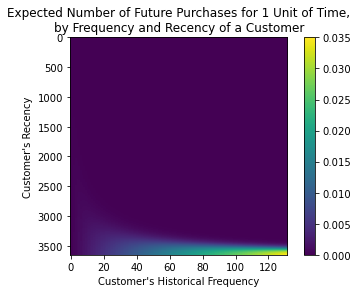

In [72]:
import matplotlib
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf_model)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

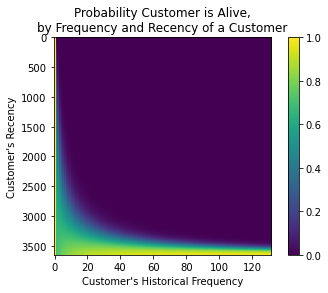

In [74]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf_model)

In [79]:
# 未来の7日間 (2011-12-01〜2011-12-07) のトランザクション数を顧客ごとに予測
t = 7
summary_df['predicted_purchases'] = bgf_model.conditional_expected_number_of_purchases_up_to_time(
    t, summary_df['frequency'], summary_df['recency'], summary_df['T']
)

# 予測トランザクション数が多いトップ5
summary_df.sort_values(by='predicted_purchases', ascending=False).head()

,frequency,recency,T,predicted_purchases
CustomerID,,,,
12713.0,0.0,0.0,3279.0,0.000496
13298.0,0.0,0.0,3280.0,0.000496
13436.0,0.0,0.0,3280.0,0.000496
14569.0,0.0,0.0,3280.0,0.000496
15520.0,0.0,0.0,3280.0,0.000496
